In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import sys
from time import time

# Problem 2

## Part a

n=10	 err=7.8903e-05	 t=0.001001119613647461
n=20	 err=1.9746e-05	 t=0.0010013580322265625
n=40	 err=4.9366e-06	 t=0.010008096694946289
n=80	 err=1.2342e-06	 t=0.1461327075958252
n=160	 err=3.0854e-07	 t=4.100726366043091

a=2.29e-07	 b=3.12


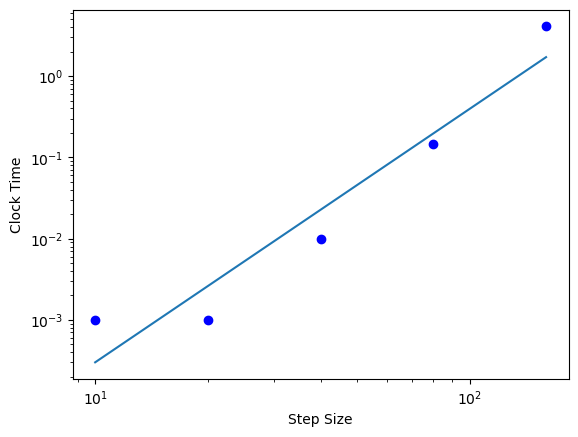

In [44]:
s=sqrt(0.75)
steps = [10,20,40,80,160]

# Function to map an interior index (i,j) into the vector index
def ind(i,j,n):
    return i-1+(j-1)*(2*n-2-j)//2

# Source term for the desired reference solution
def fun(x,y):
    return -8*(sqrt(3)-2*y)*cos(y)+4*(-4-3*x+3*x*x+sqrt(3)*y-y*y)*sin(y)

# Reference solution
def uex(x,y):
    return ((2*y-sqrt(3))**2-3*(2*x-1)**2)*sin(y)

# Function to check whether an index pair (i,j) is the interior of the grid
def inrange(i,j,n):
    return i>0 and j>0 and i+j<n

def err(u, n):  # Compute error
    h=1./n
    uerr = 0
    for j in range(1,n):
        for i in range(1,n-j):
            du = uex(h*(i+0.5*j),h*s*j) - u[ind(i,j,n)]
            uerr += du*du
    return sqrt(s*uerr/(2*n*n))
    
def poisson_tri(n):
    h=1./n
    m=(n-1)*(n-2)//2

    # Create derivative matrix and source term
    d=np.zeros((m,m))
    f=np.empty((m))
    hfac=1/(3*h*h)
    for j in range(1,n):
        for i in range(1,n-j):
            ij=ind(i,j,n)

            # Derivative matrix
            d[ij,ij]=-12*hfac
            if(inrange(i+1,j,n)): d[ij,ind(i+1,j,n)]=2*hfac
            if(inrange(i,j-1,n)): d[ij,ind(i,j-1,n)]=2*hfac
            if(inrange(i-1,j+1,n)): d[ij,ind(i-1,j+1,n)]=2*hfac

            # Additional lines for the stencil in part (b)
            if(inrange(i-1,j,n)): d[ij,ind(i-1,j,n)]=2*hfac
            if(inrange(i,j+1,n)): d[ij,ind(i,j+1,n)]=2*hfac
            if(inrange(i+1,j-1,n)): d[ij,ind(i+1,j-1,n)]=2*hfac

            # Source term
            f[ij]=fun(h*(i+0.5*j),h*s*j)

    # Solve the linear system
    u=np.linalg.solve(d,f)
    return u

# Loop over a range of grid sizes and compute the error
times = []
for n in steps:
    t0 = time()
    res = poisson_tri(n)
    t1 = time()
    print(f"n={n}\t err={err(res, n):.5}\t t={t1-t0}")
    times.append(t1 - t0)
    
A = np.asmatrix([[np.log(step), 1] for step in steps])
b, a = np.linalg.lstsq(A, np.log(times), rcond=None)[0]
a = np.exp(a)
fit = [a*n**b for n in steps]
print(f"\na={a:.3}\t b={b:.3}")

plt.loglog(steps, times, 'bo')
plt.loglog(steps, fit)
plt.xlabel("Step Size")
plt.ylabel("Clock Time")
plt.show()

## Part b

In [52]:
s=sqrt(0.75)
steps = [10,20,40,80,160]

def A(q, n, h):  # Computes Aq
    m = (n-1)*(n-2)//2
    ans = np.zeros(m)
    for j in range(1,n):
        for i in range(1,n-j):
            ij=ind(i,j,n)
            entry = -6 * q[ij]
            
            if(inrange(i+1,j,n)):
                entry += q[ind(i+1,j,n)]
            if(inrange(i,j-1,n)):
                entry += q[ind(i,j-1,n)]
            if(inrange(i-1,j+1,n)):
                entry += q[ind(i-1,j+1,n)]

            if(inrange(i-1,j,n)):
                entry += q[ind(i-1,j,n)]
            if(inrange(i,j+1,n)):
                entry += q[ind(i,j+1,n)]
            if(inrange(i+1,j-1,n)):
                entry += q[ind(i+1,j-1,n)]
            ans[ij] = 2* entry / (3*h*h)
    return ans

def two_norm(r, n):
    return np.sqrt((s/(2*n**2)) * np.dot(r,r))

def conjugate_gradient(n):
    h = 1./n
    m = (n-1)*(n-2)//2
    
    u = np.zeros(m)
    f = np.empty((m))
    for j in range(1,n):
        for i in range(1,n-j):
            ij=ind(i,j,n)
            f[ij]=fun(h*(i+0.5*j),h*s*j)
    r = f - A(u, n, h)
    p = r.copy()

    k = 0
    while True:
        w = A(p, n, h)
        rr = np.dot(r,r)
        alpha = rr/np.dot(p,w)
        u += alpha * p
        r -= alpha * w
        if two_norm(r, n) < 1e-10:
            break
        beta = np.dot(r, r)/rr
        p = r + beta * p
        k += 1
    return u, k

u, k = conjugate_gradient(40)
expected = poisson_tri(40)
print(np.linalg.norm(u - expected)**2)

1.0977114590467897e-23


## Part c-d

n=10	 err=7.8903e-05	 k=15	 t=0.002001047134399414
n=20	 err=1.9746e-05	 k=32	 t=0.013011693954467773
n=40	 err=4.9366e-06	 k=67	 t=0.12311148643493652
n=80	 err=1.2342e-06	 k=137	 t=1.0819830894470215
n=160	 err=3.0854e-07	 k=278	 t=9.651769876480103

a=1.45e-06	 b=3.08


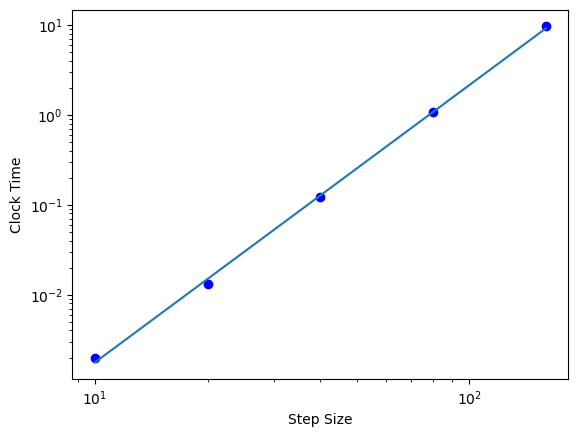

In [53]:
# Loop over a range of grid sizes and compute the error
times = []
for n in steps:
    t0 = time()
    res, k = conjugate_gradient(n)
    t1 = time()
    print(f"n={n}\t err={err(res, n):.5}\t k={k}\t t={t1-t0}")
    times.append(t1 - t0)

A = np.asmatrix([[np.log(step), 1] for step in steps])
b, a = np.linalg.lstsq(A, np.log(times), rcond=None)[0]
a = np.exp(a)
fit = [a*n**b for n in steps]
print(f"\na={a:.3}\t b={b:.3}")

plt.loglog(steps, times, 'bo')
plt.loglog(steps, fit)
plt.xlabel("Step Size")
plt.ylabel("Clock Time")
plt.show()

## Part e-f

# Problem 3

## Part c

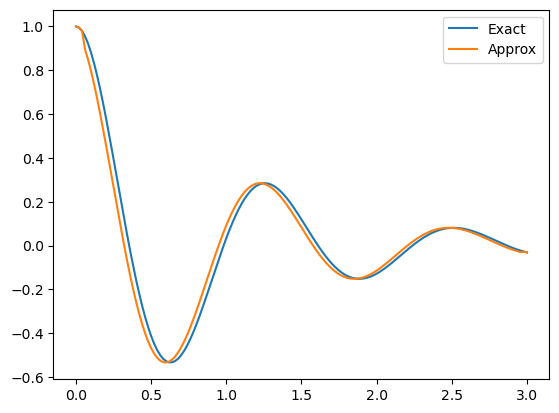

a=1.2, b=4.22


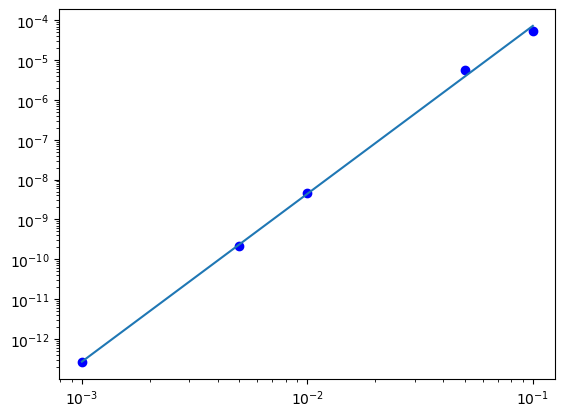

In [26]:
def f(y):
    return np.asarray([y[1], -26*y[0] + -2*y[1]])

def yex(t): # exact y(t)
    return (5 * np.cos(5*t) + np.sin(5*t)) / (5 * np.exp(t))

def yp(t): # y'(t)
    return (-26 * np.sin(5*t)) / (5 * np.exp(t))

def nystrom(h):
    n = (int)(3/h)
    ys = [[yex(i*h), yp(i*h)] for i in range(3)]
    
    for k in range(2, n):
        A = np.asarray([[1, -h/3], [26*h/3, 1 + 2*h/3]])
        b = np.asarray(ys[k-1])
        b += (h/3) * (f(ys[k-1]) + 4 * f(ys[k]))
        ys.append(np.linalg.solve(A, b))

    xs = [i*h for i in range(n+1)]
    exact_sol = [yex(x) for x in xs]
    approx_sol = [y[0] for y in ys]
    return xs, exact_sol, approx_sol

xs, exact_sol, approx_sol = nystrom(0.02)
plt.plot(xs, exact_sol, label="Exact")
plt.plot(xs, approx_sol, label="Approx")
plt.legend(loc="upper right")
plt.show()

hs = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
error = []
for h in hs:
    xs, exact_sol, approx_sol = nystrom(h)
    error.append(np.abs(exact_sol[-1] - approx_sol[-1]))

A = np.asmatrix([[np.log(h), 1] for h in hs])
b, a = np.linalg.lstsq(A, np.log(error), rcond=None)[0]
a = np.exp(a)
fit = [a*h**b for h in hs]
print(f"a={a:.3}, b={b:.3}")

plt.loglog(hs, error, 'bo')
plt.loglog(hs, fit)
plt.show()

## Part d

a=33.7, b=2.76


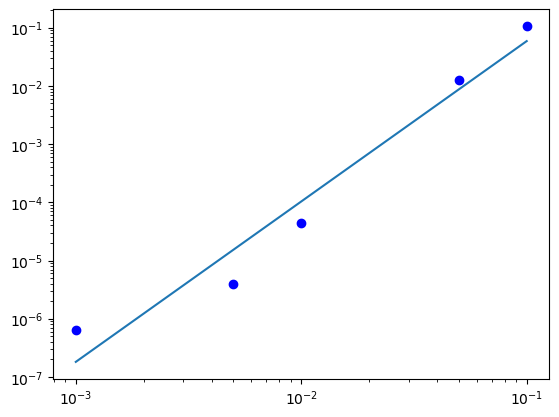

In [29]:
def nystrom_forwardEuler(h):
    n = (int)(3/h)
    ys = [np.asarray([1,0])]
    ys.append(ys[0] + h * f(ys[0]))
    ys.append(ys[1] + h * f(ys[1]))
    
    for k in range(2, n):
        A = np.asarray([[1, -h/3], [26*h/3, 1 + 2*h/3]])
        b = np.asarray(ys[k-1])
        b += (h/3) * (f(ys[k-1]) + 4 * f(ys[k]))
        ys.append(np.linalg.solve(A, b))

    xs = [i*h for i in range(n+1)]
    exact_sol = [yex(x) for x in xs]
    approx_sol = [y[0] for y in ys]
    return xs, exact_sol, approx_sol

hs = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
error = []
for h in hs:
    xs, exact_sol, approx_sol = nystrom_forwardEuler(h)
    error.append(np.abs(exact_sol[-1] - approx_sol[-1]))

A = np.asmatrix([[np.log(h), 1] for h in hs])
b, a = np.linalg.lstsq(A, np.log(error), rcond=None)[0]
a = np.exp(a)
fit = [a*h**b for h in hs]
print(f"a={a:.3}, b={b:.3}")

plt.loglog(hs, error, 'bo')
plt.loglog(hs, fit)
plt.show()